**Purpose**: Analyze the feedback that are embeded at the end of the tutorials in Galaxy Training Material

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from pprint import pprint
import datetime
import emoji

In [2]:
url = 'https://docs.google.com/spreadsheets/d/1NfZhi5Jav7kl9zFCkeb7rIC2F8xW1isruv1TeO4WpNI/export?format=tsv'

In [3]:
str(datetime.datetime.now())

'2020-12-22 15:00:32.322092'

In [4]:
col_order = ['All',
            'Introduction to Galaxy Analyses',
            'Assembly',
            'Climate',
            'Computational chemistry',
            'Ecology',
            'Epigenetics',
            'Genome Annotation',
            'Imaging',
            'Metabolomics',
            'Metagenomics',
            'Proteomics',
            'Sequence analysis',
            'Statistics and machine learning',
            'Transcriptomics',
            'Variant Analysis',
            'Visualisation',
            'User Interface and Data Manipulation',
            'Galaxy Server administration',
            'Development in Galaxy',
            'Contributing to the Galaxy Training Material',
            'Teaching and Hosting Galaxy training']

# Load the feedback

In [5]:
df = (pd.read_csv(url, sep='\t')
    # remove last column
      .drop(['Make feedback confidential?'], axis=1)
    # rename column
      .rename(columns = {'Timestamp': 'timestamp',
                         'How much did you like this tutorial?': 'note',
                         'What did you like?': 'pro',
                         'What could be improved?': 'con',
                         'Tutorial': 'tutorial_topic'}))
# extract topic from tutorial name
new = df.tutorial_topic.str[::-1].str.split('(', n = 1, expand = True)
df["tutorial"]= new[1].str[::-1].str[:-1]
df["topic"]= new[0].str[::-1].str[:-1]
df = (df.drop(columns =["tutorial_topic"])
    # remove rows with NaN on note, pro and con
      .dropna(subset=['note', 'pro', 'con'], how='all')
    # replace NaN in note by 0
      .fillna(value={'note': 0}))
# format note to integer
df.note = df.note.astype(int)
# format pro and con to string
df.pro = df.pro.astype(str)
df.con = df.con.astype(str)
# format timestamp to remove hour and use datetime
df.timestamp = pd.to_datetime(
    df.timestamp.str.split(' ', n = 1, expand = True)[0],
    dayfirst=True)
# change topic for some tutorials
df.loc[df.tutorial == 'Formation of the Super-Structures on the Inactive X', 'topic'] = 'Epigenetics'
df.loc[df.tutorial == 'Identification of the binding sites of the Estrogen receptor', 'topic'] = 'Epigenetics'
df.loc[df.tutorial == 'Identification of the binding sites of the T-cell acute lymphocytic leukemia protein 1 (TAL1)', 'topic'] = 'Epigenetics'
df.loc[df.tutorial == 'RAD-Seq Reference-based data analysis', 'topic'] = 'Ecology'
df.loc[df.tutorial == 'RAD-Seq de-novo data analysis', 'topic'] = 'Ecology'
df.loc[df.tutorial == 'RAD-Seq to construct genetic maps', 'topic'] = 'Ecology'
# replace with 'User Interface and Data Manipulation'
df.topic = (df
    .topic
    .replace(to_replace='User Interface and Features', value='User Interface and Data Manipulation')
    .replace(to_replace='Data Manipulation', value='User Interface and Data Manipulation'))

In [6]:
df.head()

,timestamp,note,pro,con,tutorial,topic
0,2018-09-09,4,nan,the clear instruction pattern,A short introduction to Galaxy,Introduction to Galaxy Analyses
1,2018-09-11,5,very detailed,nan,A short introduction to Galaxy,Introduction to Galaxy Analyses
2,2018-09-14,5,"very detailed and easy to follow, even for a c...",nan,Galaxy 101,Introduction to Galaxy Analyses
3,2018-09-15,5,"very detailed and easy to follow, thank you",nan,Introduction to Genomics and Galaxy,Introduction to Galaxy Analyses
4,2018-09-15,5,That all the tools had helpful explanations,If there was a guide to say which tool to use ...,Galaxy 101,Introduction to Galaxy Analyses


In [7]:
months = df.timestamp.dt.to_period("M")

# General stats about feedback

Feedback number:

In [8]:
# number of rows
len(df)

1479

Feedback number over time

In [9]:
nb_per_months = (df
                 .groupby(months)
                 .count())
nb_per_months.head()

,timestamp,note,pro,con,tutorial,topic
timestamp,,,,,,
2018-09,52,52,52,52,52,52
2018-10,63,63,63,63,63,63
2018-11,39,39,39,39,39,39
2018-12,28,28,28,28,28,28
2019-01,37,37,37,37,37,37


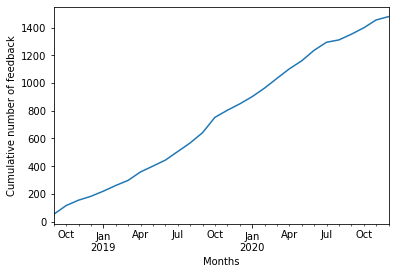

In [10]:
plt.figure()
(nb_per_months
    .timestamp
    .cumsum()
    .plot())
plt.xlabel('Months')
plt.ylabel('Cumulative number of feedback')
plt.show()

Top 10 tutorials with feedbacks

In [11]:
(df
    .groupby(by="tutorial")
    .count()
    .sort_values('timestamp', ascending=False)
    .timestamp
    .head(10))

tutorial
A short introduction to Galaxy                        371
Galaxy 101                                            111
Quality Control                                       109
From peaks to genes                                    75
Reference-based RNA-Seq data analysis                  71
Visualization of RNA-Seq results with Volcano Plot     36
NGS data logistics                                     31
Mapping                                                31
RNA-Seq reads to counts                                28
16S Microbial Analysis with mothur (extended)          26
Name: timestamp, dtype: int64

# Aggregate the feedbacks and notes

In [12]:
def get_notes(df, name):
    '''Aggregage the notes
    
    :df: dataframe with all feedbacks
    
    :return: dataframe object with aggregated notes
    '''
    return (df.note
        .value_counts(sort=False)
        .to_frame()
        .rename(columns= {'note': name}))

In [13]:
notes = get_notes(df, 'All')

In [14]:
def get_topic_df(grouped_by_topic, topic, notes):
    '''Extract the dataframe for a topic and plot note histogram
    
    :grouped_by_topic: groupby object grouping by topic
    :topic: topic to extract
    
    :return: dataframe object for the topic
    '''
    topic_df = (grouped_by_topic
        .get_group(topic)
        .drop('topic', 1))
    
    notes = pd.concat([notes, get_notes(topic_df, topic)], axis=1)
    return topic_df, notes


def extract_tutorial_feedbacks(topic_df, topic_name):
    '''Extract pro/con per tutorial for a topic and 
    write them in a file
    
    :topic_df: dataframe object for the topic
    :topic_name: name for the topic, name for the file
    '''
    grouped_by_tuto = topic_df.groupby(by="tutorial")
    with open('../results/%s.md' % topic_name, 'w') as f:
        for tuto, group in grouped_by_tuto:
            # get groups
            tuto_df = grouped_by_tuto.get_group(tuto)
            pros = []
            cons = []
            # get pros/cons
            for index, row in tuto_df.iterrows():
                if row['pro'] != 'nan':
                    pros.append("%s (*%s*)" % (row['pro'], row['timestamp']))
                if row['con'] != 'nan':
                    cons.append("%s (*%s*)" % (row['con'], row['timestamp']))
            # write in report file
            f.write("- **%s**\n" % tuto)
            if len(pros) > 0:
                f.write("  - Pro:\n    - ")
                f.write("\n    - ".join(pros))
            if len(cons) > 0:
                f.write("\n  - Con:\n    - ")
                f.write("\n    - ".join(cons))
            f.write("\n\n")

In [15]:
nb_per_months_df = (nb_per_months[['timestamp']]
    .rename(columns = {'timestamp': 'All'}))
grouped_by_topic = df.groupby(by="topic")
for topic in grouped_by_topic.groups:
    print(topic)
    topic_df, notes = get_topic_df(grouped_by_topic, topic, notes)
    topic_name = topic.lower().replace(' ', '-')
    extract_tutorial_feedbacks(topic_df, topic_name)
    m_df = (topic_df
        .groupby(months)
        .count()
        .filter(regex='timestamp')
        .rename(columns = {'timestamp': topic}))
    nb_per_months_df = nb_per_months_df.merge(m_df, how='outer', left_index=True, right_index=True)
nb_per_months_df = (nb_per_months_df
    .fillna(0))
nb_per_months_df = nb_per_months_df[col_order]
notes = notes[col_order]

Assembly
Climate
Computational chemistry
Contributing to the Galaxy Training Material
Development in Galaxy
Ecology
Epigenetics
Galaxy Server administration
Genome Annotation
Imaging
Introduction to Galaxy Analyses
Metabolomics
Metagenomics
Proteomics
Sequence analysis
Statistics and machine learning
Teaching and Hosting Galaxy training
Transcriptomics
User Interface and Data Manipulation
Variant Analysis
Visualisation


Feedback number per topics

In [16]:
(nb_per_months_df
    .sum(axis=0))

All                                             1479.0
Introduction to Galaxy Analyses                  656.0
Assembly                                          37.0
Climate                                            1.0
Computational chemistry                            7.0
Ecology                                            4.0
Epigenetics                                       51.0
Genome Annotation                                 26.0
Imaging                                            6.0
Metabolomics                                       6.0
Metagenomics                                      77.0
Proteomics                                        29.0
Sequence analysis                                140.0
Statistics and machine learning                   50.0
Transcriptomics                                  234.0
Variant Analysis                                  40.0
Visualisation                                      2.0
User Interface and Data Manipulation              32.0
Galaxy Ser

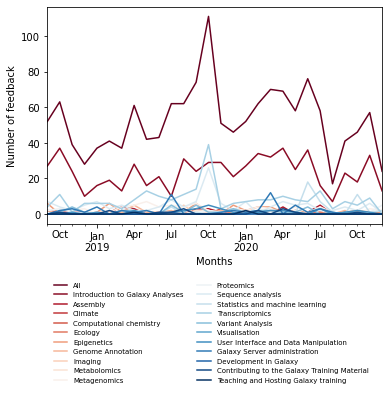

In [17]:
fig, ax = plt.subplots()
(nb_per_months_df
    .plot(ax=ax, colormap='RdBu'))
plt.xlabel('Months')
plt.ylabel('Number of feedback')
ax.legend(
    loc='center left',
    bbox_to_anchor=(0, -0.5),
    frameon=False,
    ncol=2,
    fontsize='x-small')

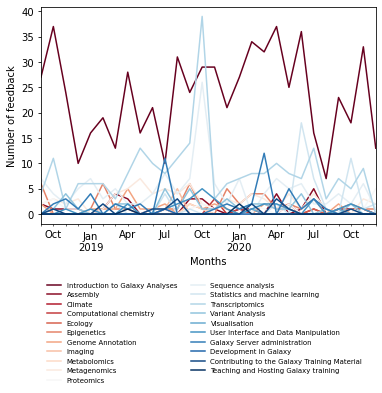

In [18]:
fig, ax = plt.subplots()
(nb_per_months_df
    .drop(columns=['All'])
    .plot(ax=ax, colormap='RdBu'))
plt.xlabel('Months')
plt.ylabel('Number of feedback')
ax.legend(
    loc='center left',
    bbox_to_anchor=(0, -0.5),
    frameon=False,
    ncol=2,
    fontsize='x-small')

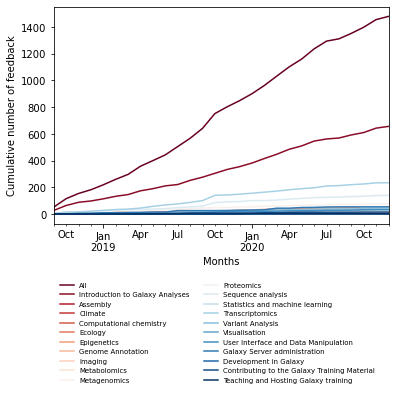

In [19]:
fig, ax = plt.subplots()
(nb_per_months_df
    .cumsum()
    .plot(ax=ax, colormap='RdBu'))
plt.xlabel('Months')
plt.ylabel('Cumulative number of feedback')
ax.legend(
    loc='center left',
    bbox_to_anchor=(0, -0.5),
    frameon=False,
    ncol=2,
    fontsize='x-small')

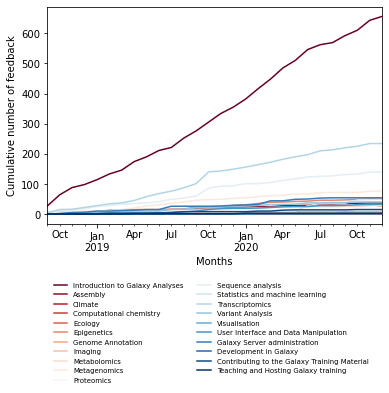

In [20]:
fig, ax = plt.subplots()
(nb_per_months_df
    .drop(columns=['All'])
    .cumsum()
    .plot(ax=ax, colormap='RdBu'))
plt.xlabel('Months')
plt.ylabel('Cumulative number of feedback')
ax.legend(
    loc='center left',
    bbox_to_anchor=(0, -0.5),
    frameon=False,
    ncol=2,
    fontsize='x-small')

Details (pros/cons) for each tutorials are available: https://github.com/bebatut/galaxy-training-material-stats/tree/master/results

# Notes

In [21]:
def plot_note_histogram(s, title):
    plt.figure()
    s.plot(kind='barh', color='k', ylim=(0,5), xlim=(0,1), title=title)
    plt.xlabel('Proportion of feedback')
    plt.show()

In [22]:
notes = (notes
         .fillna(0.0)
         .astype(int)
         .rename(index = {0: 'No value'}))
# 1: emoji.emojize(':-1:', use_aliases=True)
# 5: emoji.emojize(':heart:', use_aliases=True)
notes_prop = (notes/notes.sum().round(2))

In [23]:
notes

,All,Introduction to Galaxy Analyses,Assembly,Climate,Computational chemistry,Ecology,Epigenetics,Genome Annotation,Imaging,Metabolomics,...,Sequence analysis,Statistics and machine learning,Transcriptomics,Variant Analysis,Visualisation,User Interface and Data Manipulation,Galaxy Server administration,Development in Galaxy,Contributing to the Galaxy Training Material,Teaching and Hosting Galaxy training
No value,22,8,1,0,0,0,1,2,0,0,...,0,0,6,1,0,0,1,0,0,0
1,60,22,1,0,1,0,2,5,0,0,...,6,0,7,8,0,2,1,0,2,0
2,35,13,2,0,0,0,3,2,0,0,...,3,1,2,2,0,3,0,0,1,0
3,82,28,3,0,1,0,3,2,0,0,...,11,3,13,2,0,3,4,0,1,0
4,285,106,11,0,1,0,16,6,0,1,...,36,12,45,6,0,12,8,0,0,1
5,995,479,19,1,4,4,26,9,6,5,...,84,34,161,21,2,12,40,1,11,2


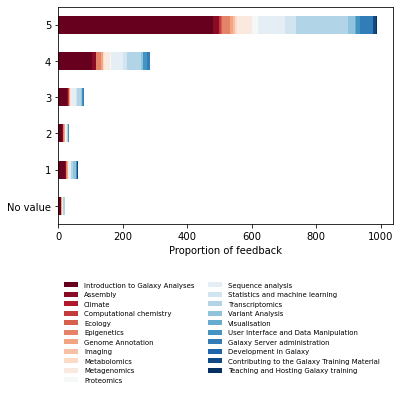

In [24]:
fig, ax = plt.subplots()
(notes
    .drop(columns=['All'])
    .plot.barh(stacked=True, ax=ax, colormap='RdBu'))
plt.xlabel('Proportion of feedback')
ax.legend(
    loc='center left',
    bbox_to_anchor=(0, -0.5),
    frameon=False,
    ncol=2,
    fontsize='x-small')

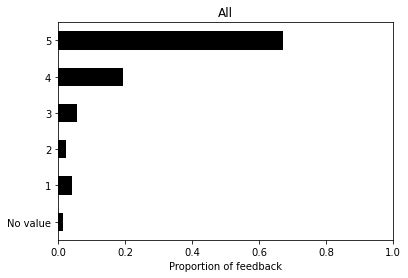

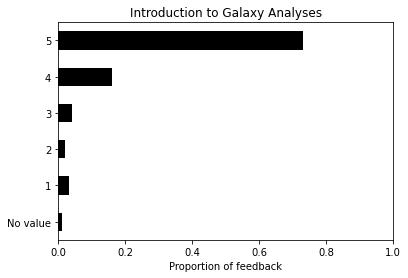

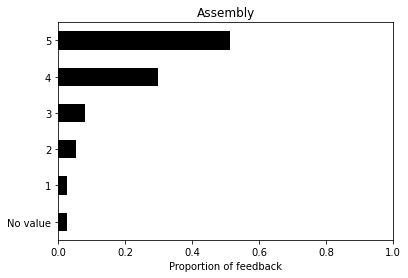

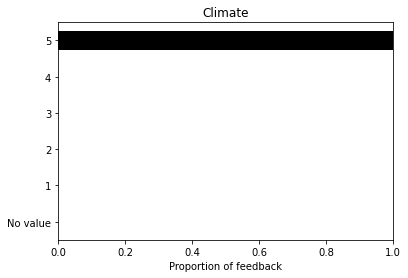

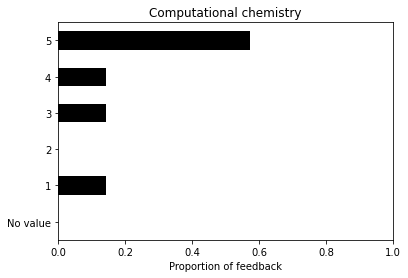

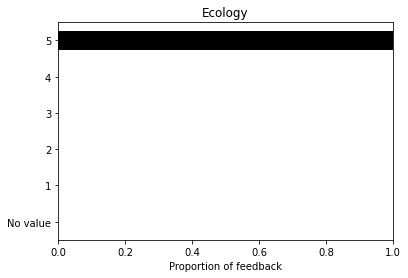

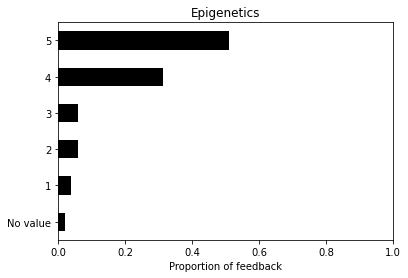

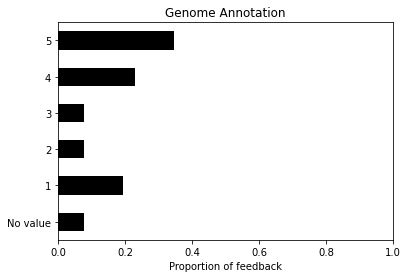

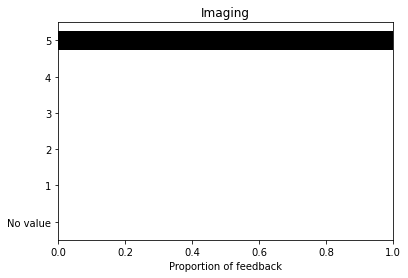

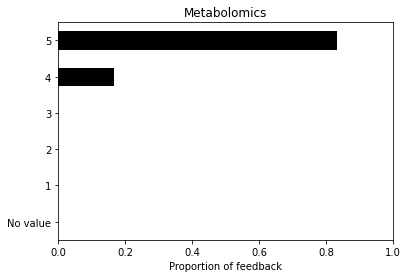

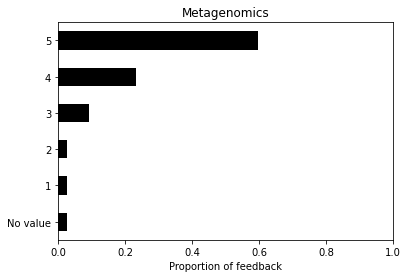

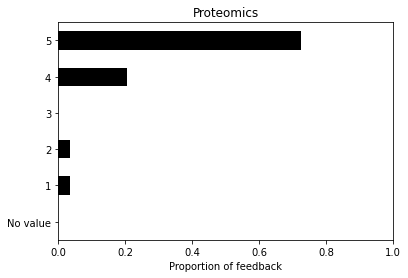

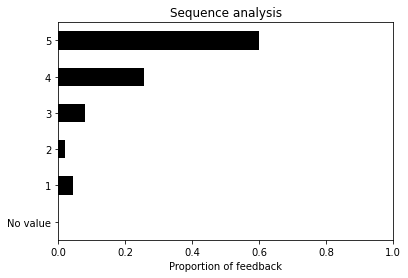

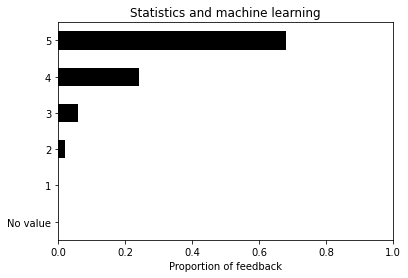

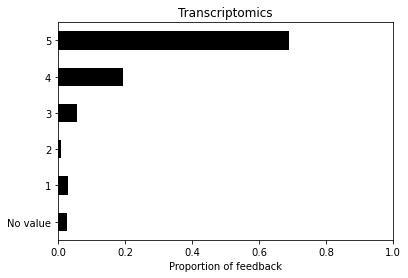

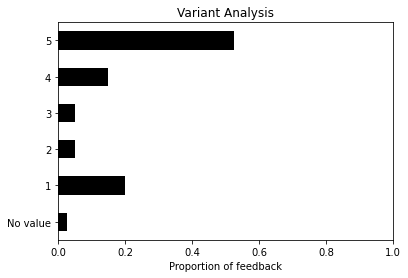

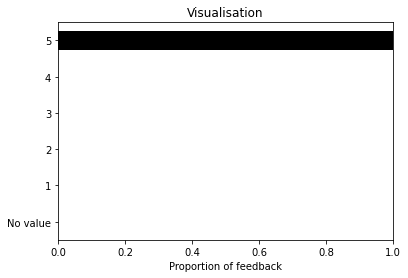

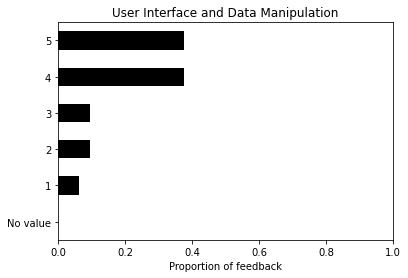

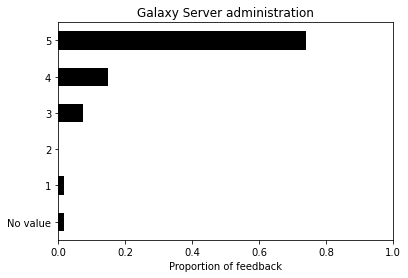

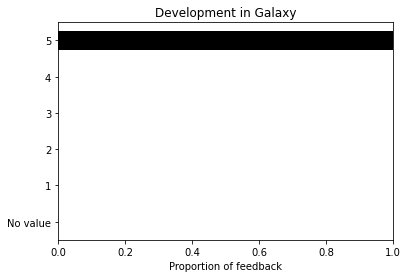

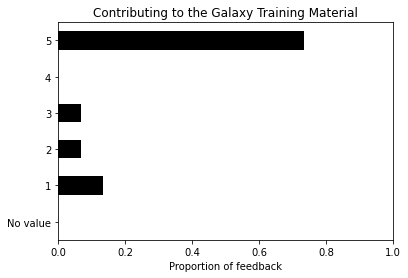

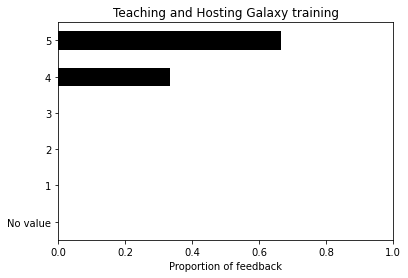

In [25]:
notes_prop = (notes/notes.sum().round(2))
for col in notes_prop.columns:
    plot_note_histogram(notes_prop[col], col)

In [26]:
notes_prop

,All,Introduction to Galaxy Analyses,Assembly,Climate,Computational chemistry,Ecology,Epigenetics,Genome Annotation,Imaging,Metabolomics,...,Sequence analysis,Statistics and machine learning,Transcriptomics,Variant Analysis,Visualisation,User Interface and Data Manipulation,Galaxy Server administration,Development in Galaxy,Contributing to the Galaxy Training Material,Teaching and Hosting Galaxy training
No value,0.014875,0.012195,0.027027,0.0,0.000000,0.0,0.019608,0.076923,0.0,0.000000,...,0.000000,0.00,0.025641,0.025,0.0,0.00000,0.018519,0.0,0.000000,0.000000
1,0.040568,0.033537,0.027027,0.0,0.142857,0.0,0.039216,0.192308,0.0,0.000000,...,0.042857,0.00,0.029915,0.200,0.0,0.06250,0.018519,0.0,0.133333,0.000000
2,0.023665,0.019817,0.054054,0.0,0.000000,0.0,0.058824,0.076923,0.0,0.000000,...,0.021429,0.02,0.008547,0.050,0.0,0.09375,0.000000,0.0,0.066667,0.000000
3,0.055443,0.042683,0.081081,0.0,0.142857,0.0,0.058824,0.076923,0.0,0.000000,...,0.078571,0.06,0.055556,0.050,0.0,0.09375,0.074074,0.0,0.066667,0.000000
4,0.192698,0.161585,0.297297,0.0,0.142857,0.0,0.313725,0.230769,0.0,0.166667,...,0.257143,0.24,0.192308,0.150,0.0,0.37500,0.148148,0.0,0.000000,0.333333
5,0.672752,0.730183,0.513514,1.0,0.571429,1.0,0.509804,0.346154,1.0,0.833333,...,0.600000,0.68,0.688034,0.525,1.0,0.37500,0.740741,1.0,0.733333,0.666667
